## Probe Generalisation MVP

### Goals:
- [x] Choose a layer to train linear probes at
  - For now, we're doing layer 5, since that's the earliest layer that got perfect accuracy in the initial probe exploration
- [ ] For each category in the 19th Feb dataset, train a linear probe
- [ ] Generate a heatmap plot, where the (x, y)-th entry is the accuracy of the probe trained on x data, predicted on y data
- [ ] Understand GPU capacity - can we do inference with 70B?

### Timeline:
- 19/02/25 and 20/02/25

In [3]:
# Imports
from models_under_pressure.probes import (
    create_activations,
    train_single_layer,
    compute_accuracy,
)

from transformers import AutoTokenizer, AutoModelForCausalLM
import os
import pandas as pd
from pathlib import Path

project_root = Path("..").resolve()

/home/ucabwjn/models-under-pressure/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Loading dataset
df = pd.read_csv(project_root / "temp_data/dataset_19_feb.csv")

# Split data by top category
categories = {}
for category in df["top_category"].unique():
    category_df = df[df["top_category"] == category]
    categories[category] = {
        "X": category_df["prompt_text"].tolist(),
        "y": category_df["high_stakes"].tolist(),
    }


In [5]:
# Loading model

os.environ["TOKENIZERS_PARALLELISM"] = "false"
model_name = "meta-llama/Llama-3.2-1B-Instruct"

# device = 'cuda:1'
device = "cpu"

# Load the LLaMA-3-1B model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Run the model on each category's data, recording the activations

for category in categories:
    categories[category]["acts"] = create_activations(
        model=model, tokenizer=tokenizer, text=categories[category]["X"], device=device
    )

Layer: 0, Activation Shape: torch.Size([100, 33, 2048])
Layer: 1, Activation Shape: torch.Size([100, 33, 2048])
Layer: 2, Activation Shape: torch.Size([100, 33, 2048])
Layer: 3, Activation Shape: torch.Size([100, 33, 2048])
Layer: 4, Activation Shape: torch.Size([100, 33, 2048])
Layer: 5, Activation Shape: torch.Size([100, 33, 2048])
Layer: 6, Activation Shape: torch.Size([100, 33, 2048])
Layer: 7, Activation Shape: torch.Size([100, 33, 2048])
Layer: 8, Activation Shape: torch.Size([100, 33, 2048])
Layer: 9, Activation Shape: torch.Size([100, 33, 2048])
Layer: 10, Activation Shape: torch.Size([100, 33, 2048])
Layer: 11, Activation Shape: torch.Size([100, 33, 2048])
Layer: 12, Activation Shape: torch.Size([100, 33, 2048])
Layer: 13, Activation Shape: torch.Size([100, 33, 2048])
Layer: 14, Activation Shape: torch.Size([100, 33, 2048])
Layer: 15, Activation Shape: torch.Size([100, 33, 2048])
All activations shape: torch.Size([16, 100, 33, 2048])
Layer: 0, Activation Shape: torch.Size([100

In [6]:
model_params = {"C": 1, "random_state": 42, "fit_intercept": False}

# For each category, train a linear probe on the activations for layer 5:
for category in categories:
    categories[category]["probe"] = train_single_layer(
        categories[category]["acts"][5], categories[category]["y"], model_params
    )

for i, category1 in enumerate(categories):
        categories[category1]["accuracy"] = [compute_accuracy(
            categories[category1]["probe"], categories[category2]["acts"][5], categories[category2]["y"]
        ) for j, category2 in enumerate(categories)]

In [8]:
accuracy_matrix

,Medical,Financial,Misinformation,Regulatory and compliance
0,1.00,1.00,1.00,0.91
1,0.98,1.00,0.95,0.88
2,0.97,0.96,1.00,0.68
3,1.00,1.00,1.00,1.00


Notes:

- We need to fix y axis labels and make it clear which axis is probes and which is dataset
- We need a better colour scheme: red should be bad!
- Clearly communicate the experimental procedure
- Put all of this in a doc with some time before the meeting tomorrow (20th Feb)


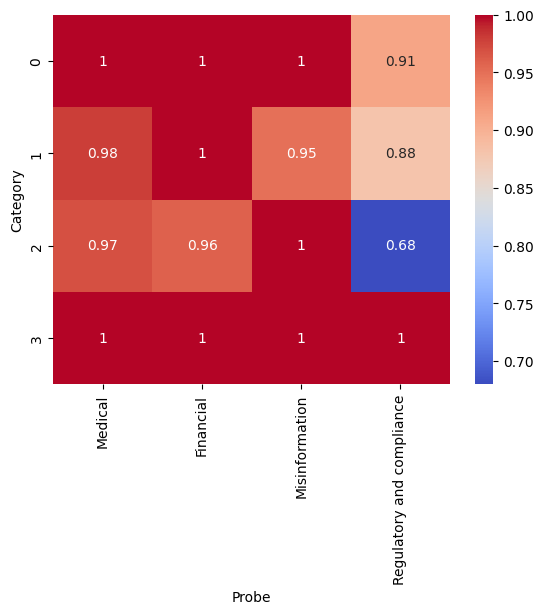

In [12]:
# Plot the categories[category]['accuracy'] values in a heatmap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

accuracy_matrix = pd.DataFrame(
    {category: categories[category]["accuracy"] for category in categories}
)

sns.heatmap(accuracy_matrix, annot=True, cmap="coolwarm")
plt.xlabel('Probe')
plt.ylabel('Category')
plt.show()
